# Practical Statistics for Data Scientists (Python)
# Chapter 7. Unsupervised Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [34]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

pip install prince

In [35]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [36]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

# Principal Components Analysis
## A simple example

In [37]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In Python, we can use the scikit-learn implementation sklearn.decomposition.PCA:

In [38]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


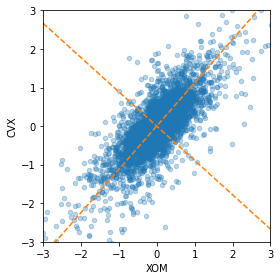

In [39]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

## Interpreting principal components

The information to create a loading plot from the scikit-learn result is available in `explained_variance_`. Here, we convert it into a pandas data frame and use it to make a bar chart:

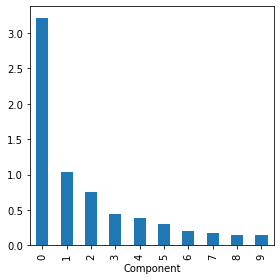

In [40]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [41]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

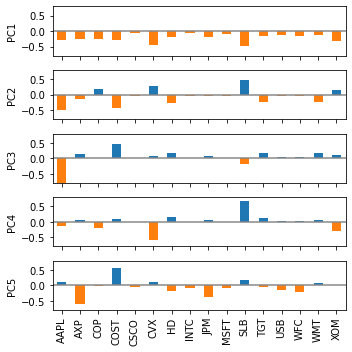

In [42]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The loadings for the top five components are shown in Figure 7-3.
- The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend).
- The second component captures the price changes of energy stocks as compared to the other stocks.
- The third component is primarily a contrast in the movements of Apple and CostCo.
- The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks.
- Finally, the fifth component is mostly dominated by financial companies.

## Correspondence analysis

In Python, we can use the prince package, which implements correspondence analysis using the scikit-learn API:

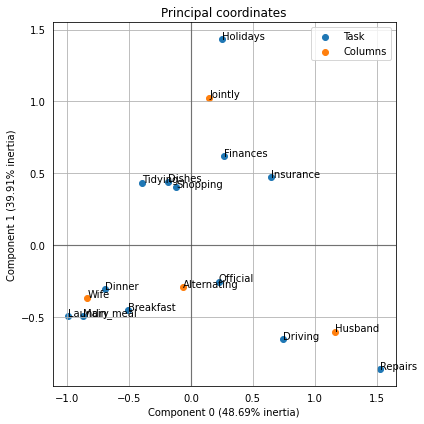

In [43]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

# K-Means Clustering
## A Simple Example

We use the sklearn.cluster.KMeans method from scikit-learn in Python to perform K-means clustering:

In [44]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        2
2011-01-04  0.168668 -0.584516        0
2011-01-05  0.026631  0.446985        2
2011-01-06  0.248558 -0.919751        0
2011-01-07  0.337329  0.180511        2


The means of the clusters:

In [45]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0 -0.328125 -0.564848
1  0.960948  1.376572
2  0.242519  0.336479
3 -1.137958 -1.746642


In this example, with just two variables, it is straightforward to visualize the clusters and their means. The seaborn scatterplot function makes it easy to color (hue) and style (style) the points by a property:

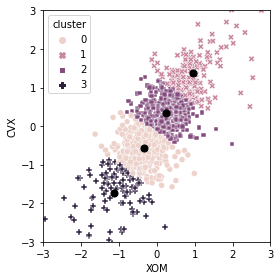

In [46]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

## K-Means Algorithm
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations. 

In [47]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

## Interpreting the Clusters

The two most important outputs from kmeans are the sizes of the clusters and the cluster means. In Python, we can use the collections.Counter class from the standard library to get this information. Due to differences in the implementation and the inherent randomness of the algorithm, results will vary:

In [48]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({2: 302, 3: 289, 4: 248, 0: 187, 1: 105})


You can plot the centers of the clusters using the gather function in conjunction with ggplot.The code to create this visualization in Python is similar to what we used for PCA:

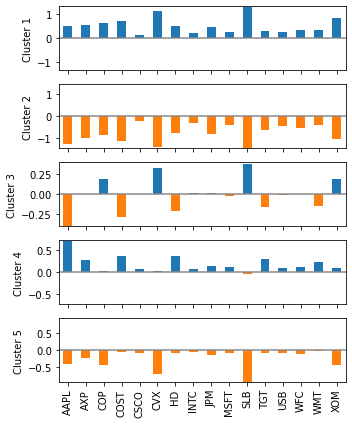

In [49]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The resulting plot is shown in Figure 7-6 and reveals the nature of each cluster.
- For example, clusters 4 and 5 correspond to days on which the market is down and up, respectively.
- Clusters 2 and 3 are characterized by up-market days for consumer stocks and down-market days for energy stocks, respectively.
- Finally, cluster 1 captures the days in which energy stocks were up and consumer stocks were down.

## Selecting the Number of Clusters

For the KMeans result, we get the information (P note:summary of clusters and the cumulative percent of variance explained for the data P note) from the property inertia_. After conversion into a pandas data frame, we can use its plot method to create the graph:

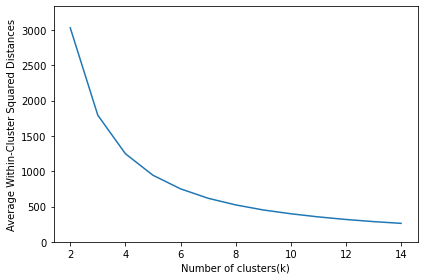

In [50]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Hierarchical Clustering
## A Simple Example

The scipy package offers a number of different methods for hierarchical clustering in the `scipy.cluster.hierarchy` module. Here we use the linkage function with the “complete” method:

In [51]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


## The Dendrogram

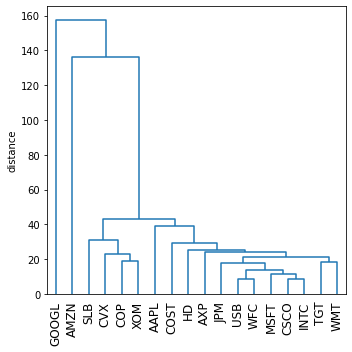

In [52]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

To extract a specific number of clusters

In [53]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


## Measures of Dissimilarity

Figure 7-9 applies hierarchical clustering using the four measures to the ExxonMobil and Chevron stock returns. For each measure, four clusters are retained.

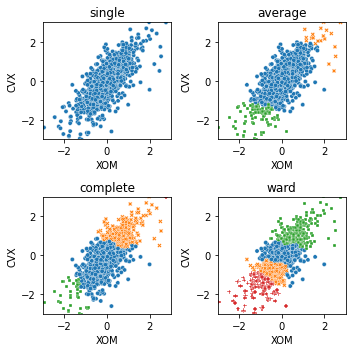

In [54]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

# Model based clustering
## Multivariate Normal Distribution
> Define a colormap that corresponds to the probability levels

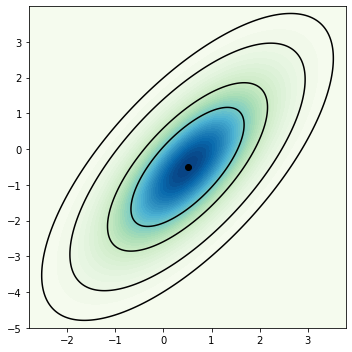

In [55]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

## Mixtures of Normals

scikit-learn has the sklearn.mixture.GaussianMixture class for model-based clustering:

In [56]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.3203170532615


Extracting the cluster assignments using the predict function, we can visualize the clusters:

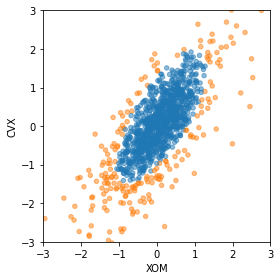

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

You can extract the parameters to the normal distributions using the `means_` and `covariances_` properties of the result:

In [58]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[ 0.0709161   0.10228006]
 [-0.05074943 -0.21539465]]
Covariances
[[[0.27074158 0.27800893]
  [0.27800893 0.5212865 ]]

 [[0.98668327 0.99350046]
  [0.99350046 1.69695919]]]


## Selecting the number of clusters

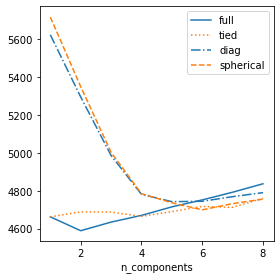

In [59]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

# Scaling and Categorical Variables
## Scaling the Variables

Variables with very different scale and units need to be normalized appropriately before you apply a clustering procedure. For example, let’s apply kmeans to a set of data of loan defaults *without normalizing*:

In [60]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  18275.132345   83354.634595  19635.189254  11.664373  16.774586   
1  21852.701005  165407.730318  38907.295645  12.597152  13.466876   
2  10591.893792   42453.058692  10268.048598   9.583820  17.713563   
3  22570.192308  489783.403846  85161.346154  13.326923   6.907500   

   revol_util   size  
0   62.258588   7543  
1   63.634900   1194  
2   58.111226  13882  
3   59.651923     52  


See what happens to the clusters when kmeans is applied to the *normalized data*:

In Python, we can use scikit-learn’s `StandardScaler`. The `inverse_transform` method allows converting the cluster centers back to the original scale:

In [61]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  10499.824632   51070.958451  11629.172535   7.511129  15.965747   
1  10315.255666   53468.181307   6032.616033   8.637385  11.255855   
2  25920.260952  116308.326663  32827.641428  12.389941  16.204021   
3  13420.700048   55844.852918  16370.832021  14.334512  24.189881   

   revol_util  size  
0   77.806693  7405  
1   31.000342  5339  
2   66.172004  3701  
3   59.227862  6226  


The cluster sizes are more balanced, and the clusters are not dominated by annual_inc and revol_bal, revealing more interesting structure in the data

## Dominant Variables

Even in cases where the variables are measured on the same scale and accurately reflect relative importance (e.g., movement to stock prices), it can sometimes be useful to rescale the variables.
Suppose we add Google (GOOGL) and Amazon (AMZN) to the analysis in “Interpreting Principal Components” on page 289. We see how this is done in Python below:

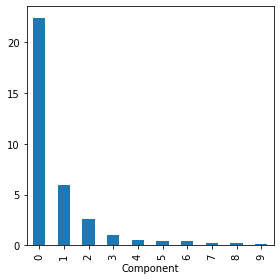

In [62]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

The screeplot displays the variances for the top principal components. In this case, the screeplot in Figure 7-13 reveals that the variances of the first and second components are much larger than the others. This often indicates that one or two variables dominate the loadings. This is, indeed, the case in this example:

In [63]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


To handle this situation, you can either include them as is, rescale the variables (see “Scaling the Variables” on page 319), or exclude the dominant variables from the analysis and handle them separately. There is no “correct” approach, and the treat‐ ment depends on the application.

## Categorical Data and Gower's Distance
> Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

https://github.com/scikit-learn/scikit-learn/pull/9555/

In [64]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

## Problems with Clustering Mixed Data

K-means and PCA are most appropriate for continuous variables. For smaller data sets, it is better to use hierarchical clustering with Gower’s distance. In principle, there is no reason why K-means can’t be applied to binary or categorical data. You would usually use the “one hot encoder” representation (see “One Hot Encoder” on page 242) to convert the categorical data to numeric values. In practice, however, using K-means and PCA with binary data can be difficult.

If the standard z-scores are used, the binary variables will dominate the definition of the clusters. This is because 0/1 variables take on only two values, and K-means can obtain a small within-cluster sum-of-squares by assigning all the records with a 0 or 1 to a single cluster. For example, apply kmeans to loan default data including factor variables home and pub_rec_zero, shown here in R:

In [65]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  16.992128           9.105395  1.000000e+00    1.176836e-14 -1.332268e-15   
1  17.456244           8.422914  1.000000e+00    1.000000e+00 -1.193490e-15   
2  16.504955           8.064247  1.110223e-16    5.156600e-01  9.714451e-17   
3  17.197993           9.266666  9.179025e-01   -6.106227e-16  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1 -2.164935e-15  
2  4.843400e-01  
3  1.998401e-15  


The top four clusters are essentially proxies for the different levels of the factor variables. To avoid this behavior, you could scale the binary variables to have a smaller variance than other variables. Alternatively, for very large data sets, you could apply clustering to different subsets of data taking on specific categorical values. For example, you could apply clustering separately to those loans made to someone who has a mortgage, owns a home outright, or rents.